## Environment setup

In [2]:
import glob, os
from functools import partial
import importlib

import tensorflow as tf

### Test data set preparation

In [3]:
import io_functions as io
importlib.reload(io)

from architecture_definitions import *

batchSize = 4096
nEpochs=1

testDataDir = "/scratch_ssd/akalinow/ProgrammingProjects/MachineLearning/OMTF/data/18_12_2020/" 
testFileNames = glob.glob(testDataDir+'OMTFHits_pats0x0003_newerSample_files_1_100_chunk_0.tfrecord.gzip')

testDataDir = "/scratch_cmsse/alibordi/data/"
testFileNames = glob.glob(testDataDir+'*15Feb*tfrecord.gzip')

dataset = io.get_Classic_NN_dataset(batchSize, nEpochs, testFileNames, isTrain=False)

Reading data from files:
/scratch_cmsse/alibordi/data/omtfAnalysis_15Feb.tfrecord.gzip


2023-03-17 17:16:36.971530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 17:16:36.975416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 17:16:36.975643: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-17 17:16:36.976552: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Load selected model version

In [4]:
import utility_functions as utils
importlib.reload(utils)

trainingSet = utils.getLatestModelPath(pattern="classic")
print("Using training set:",trainingSet)

job_dir = "results/"+trainingSet
os.makedirs(job_dir, exist_ok=True)

plot_dir = job_dir + "/figures"
os.makedirs(plot_dir, exist_ok=True)

checkpoint_path = "training/"+trainingSet

model = tf.keras.models.load_model(checkpoint_path)
model.summary()

Using training set: 2023_Mar_17_17_13_49_classic_128_64_48_1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pt_layer_1 (Dense)          (None, 128)               4864      
                                                                 
 pt_layer_2 (Dense)          (None, 64)                8256      
                                                                 
 pt_layer_3 (Dense)          (None, 48)                3120      
                                                                 
 dense (Dense)               (None, 1)                 49        
                                                                 
Total params: 16,289
Trainable params: 16,289
Non-trainable params: 0
_________________________________________________________________


### Run the model and put the result into Pandas DataFrame

ptGenPtRec.shape (800, 800)
xedges.shape (801,)
yedges.shape (801,)


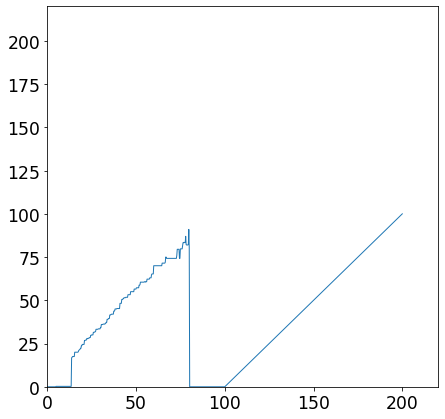

In [5]:
import utility_functions as utils
importlib.reload(utils)

import plotting_functions as plf
importlib.reload(plf)

modelAnswerPostProc = partial(utils.classicNNAnswerPostProc, output_type=output_type)

df = utils.df

for aBatch in dataset.take(10): 
    df = utils.fillPandasDataset(aBatch, df, model, modelAnswerPostProc)  
    
ptToPtCalibNN, xedges = plf.ptRecalibration(df, plot_dir, oneOverPt, "NN_pt")
df["NN_pt_recalib"] = plf.ptRecalibrated(df["NN_pt"], ptToPtCalibNN, xedges)     

### Make the plots

MeanAbsoluteError NN 7.321659
MeanAbsoluteError NN recalib. 11.439237707853318
MeanAbsoluteError OMTF 12.264514
MeanSquaredError NN 196.077
MeanSquaredError NN recalib 373.0381852809238
MeanSquaredError OMTF 669.32825
ptCut: 10 qualityCut: 12, eff@plateau: 0.81
ptCut: 15 qualityCut: 12, eff@plateau: 0.81
ptCut: 20 qualityCut: 12, eff@plateau: 0.81
ptCut: 25 qualityCut: 12, eff@plateau: 0.80
ptCut: 30 qualityCut: 12, eff@plateau: 0.80
ptCut: 40 qualityCut: 12, eff@plateau: 0.76


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


rates NN Rate @10 GeV:nan, @20 GeV: nan


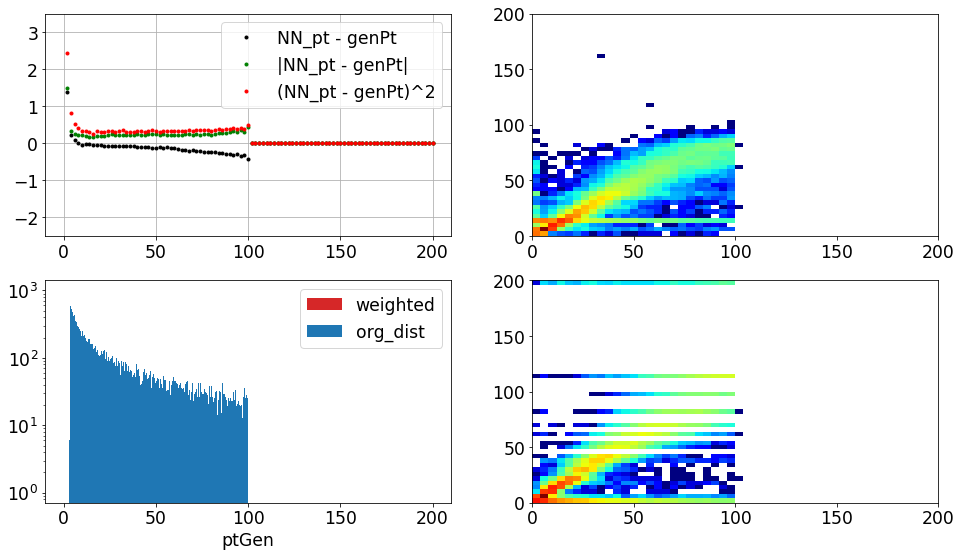

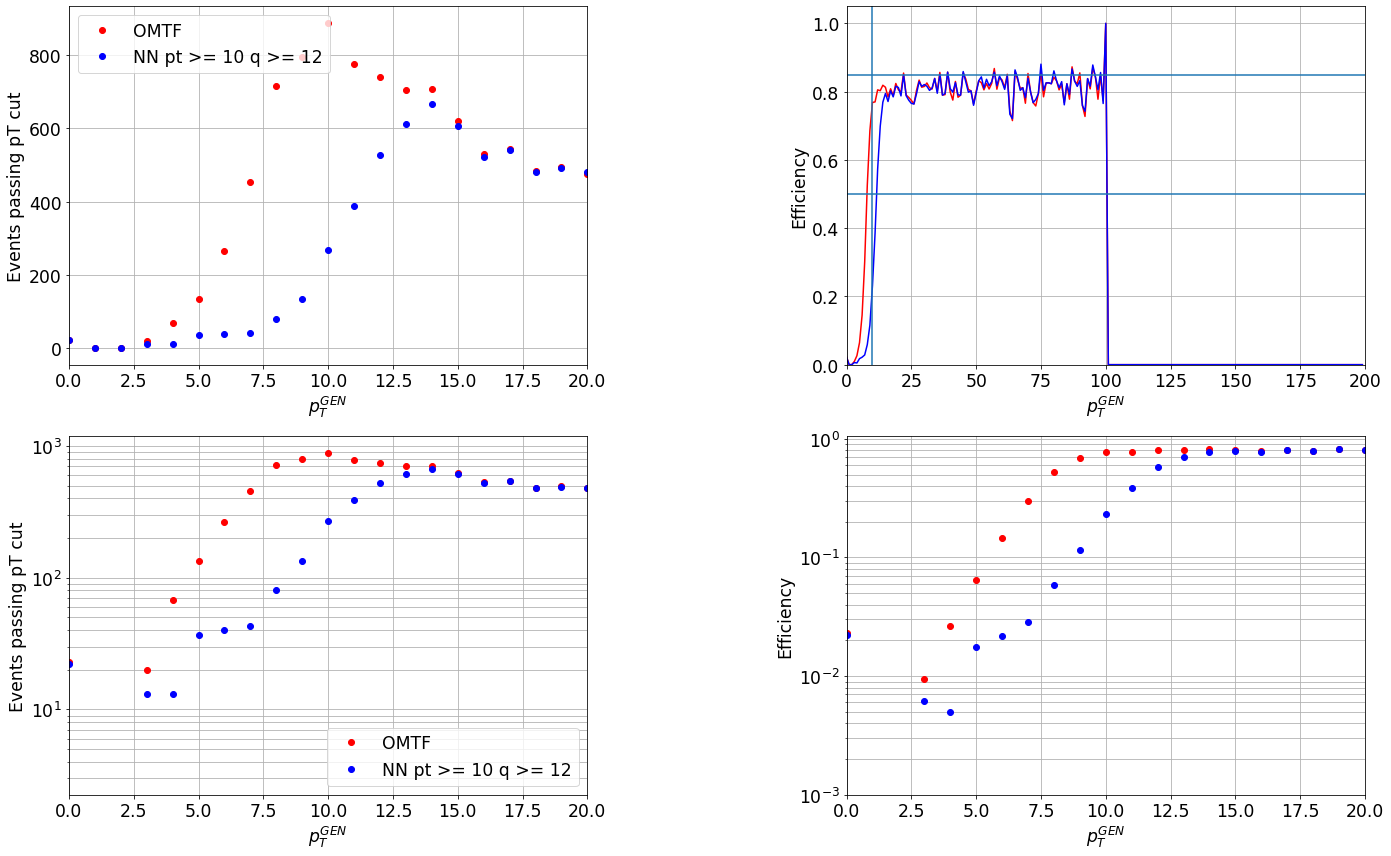

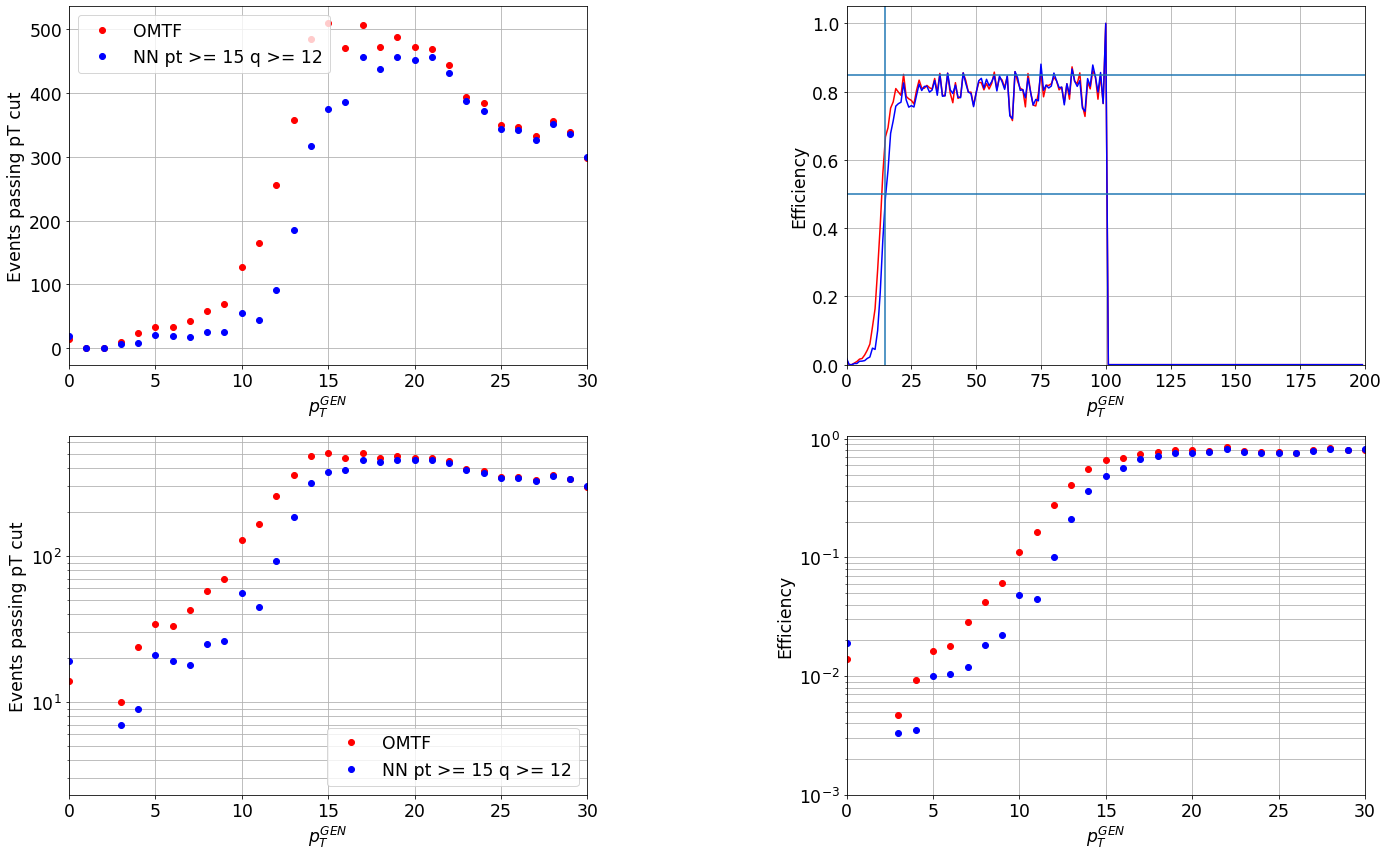

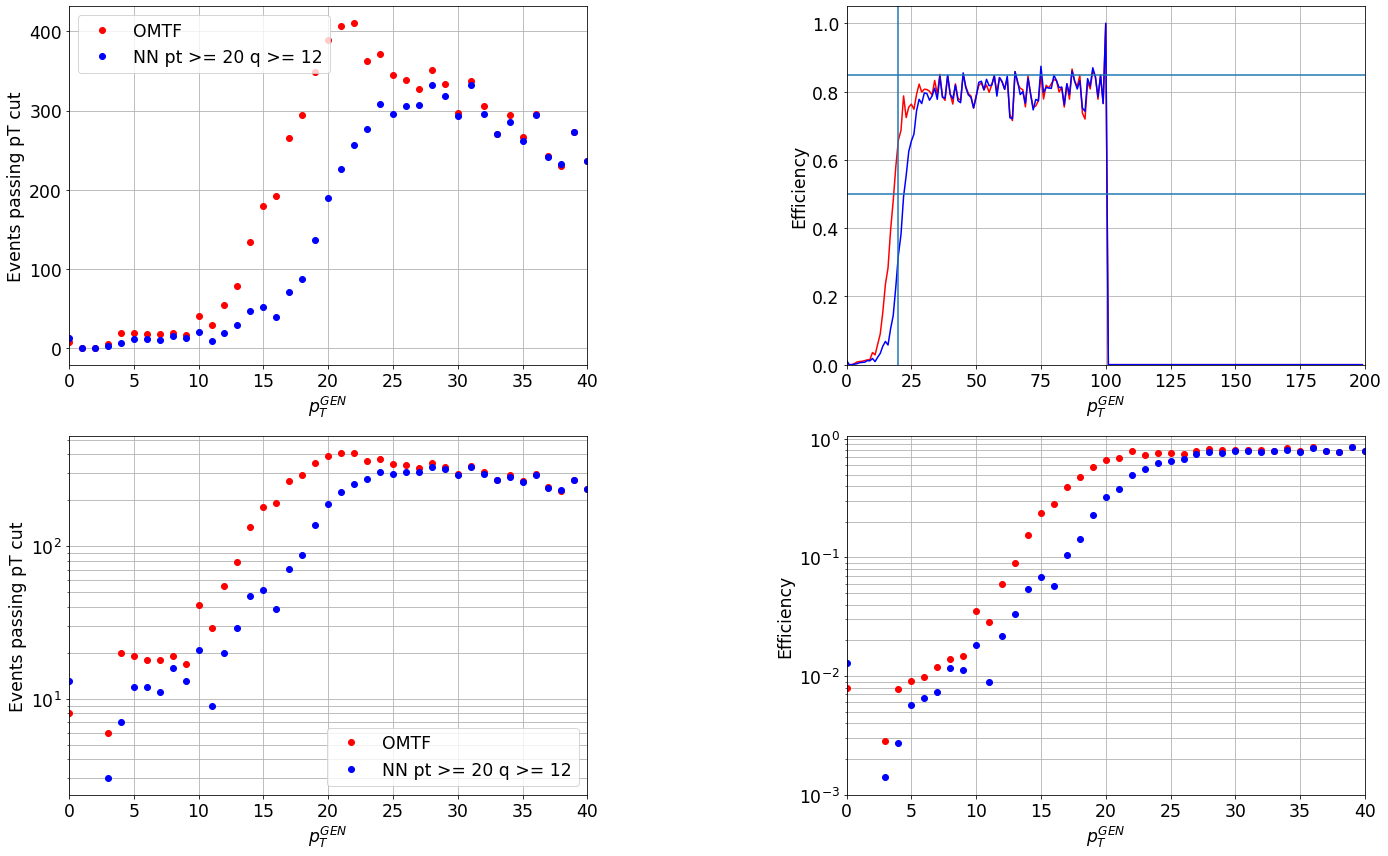

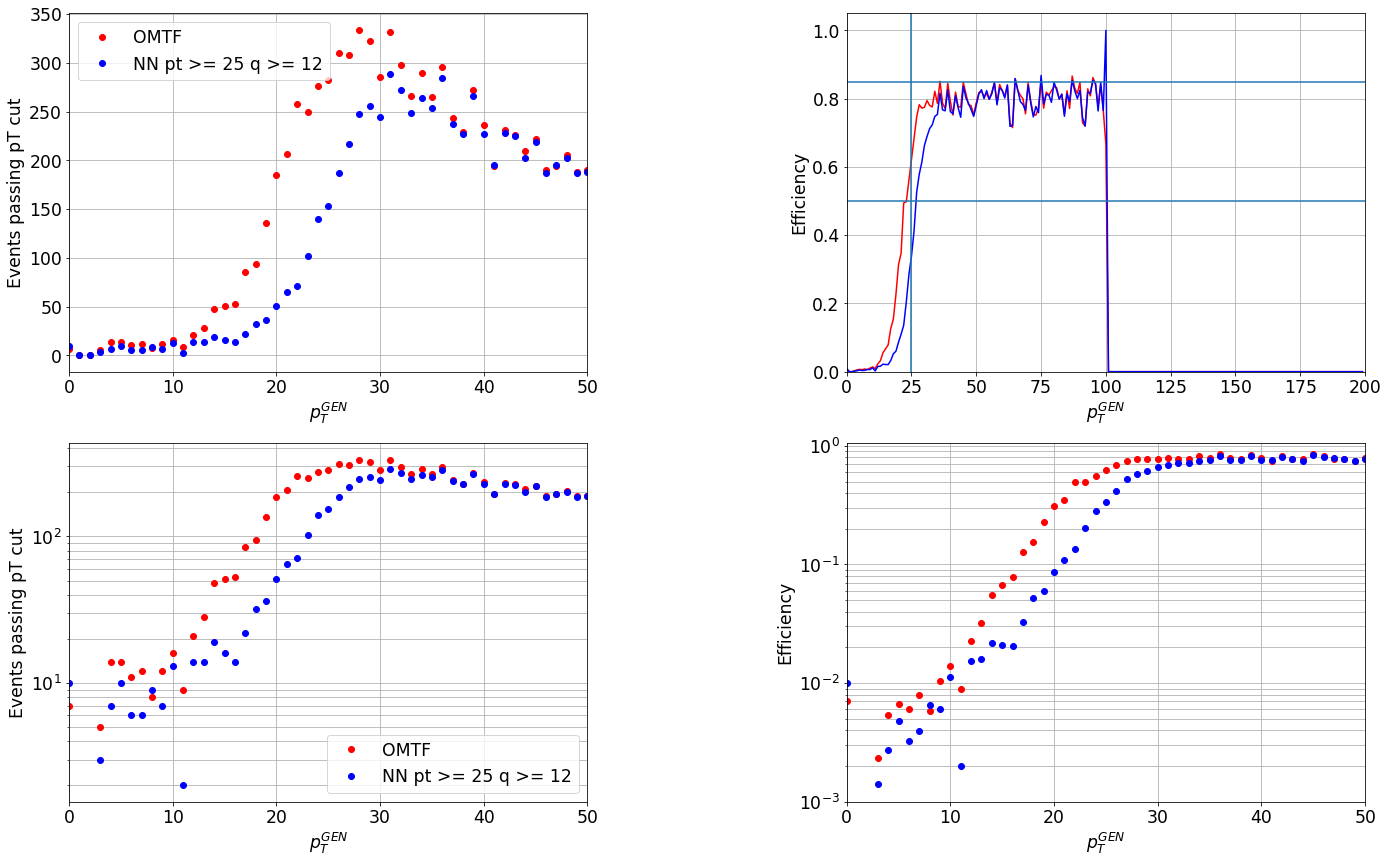

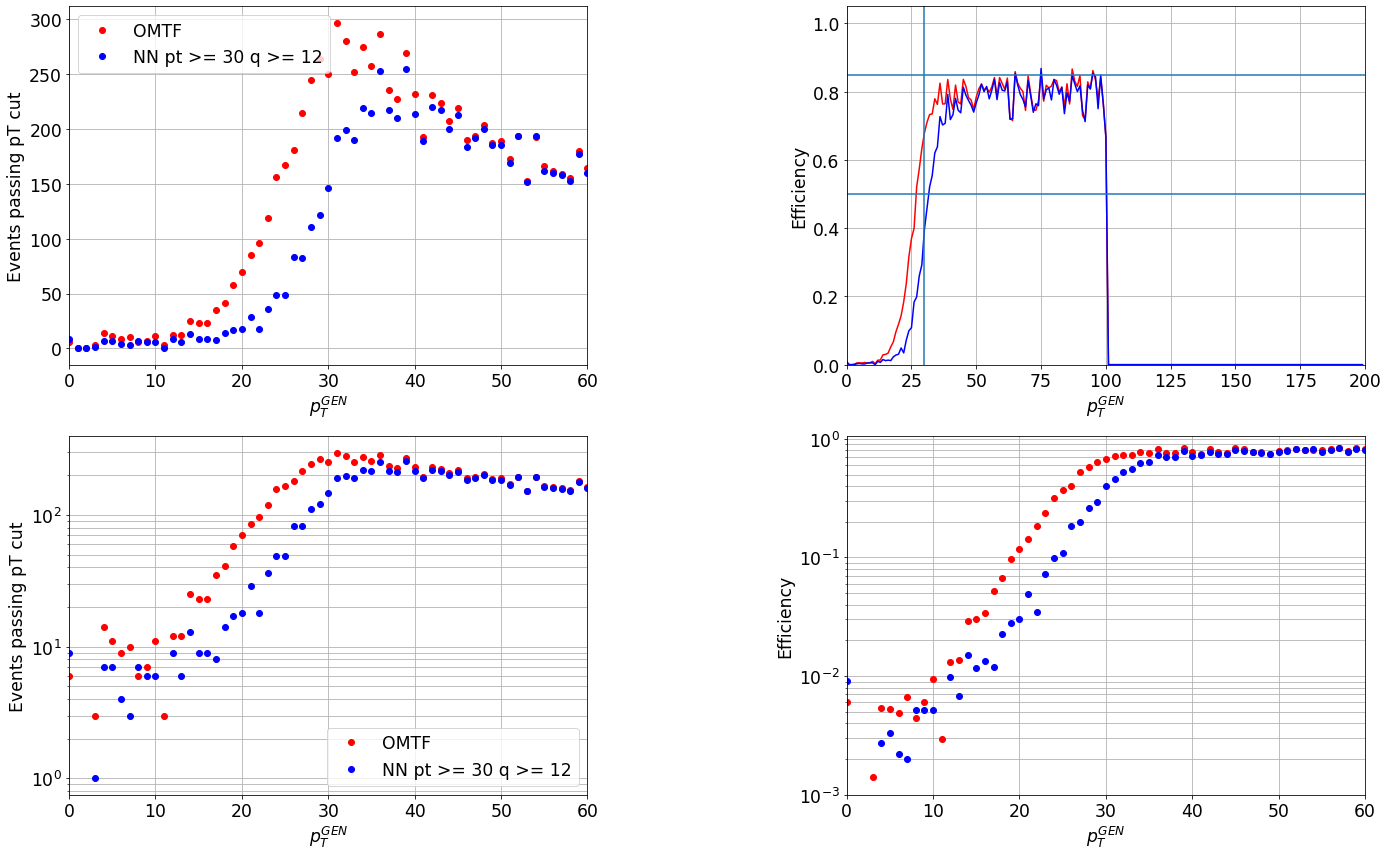

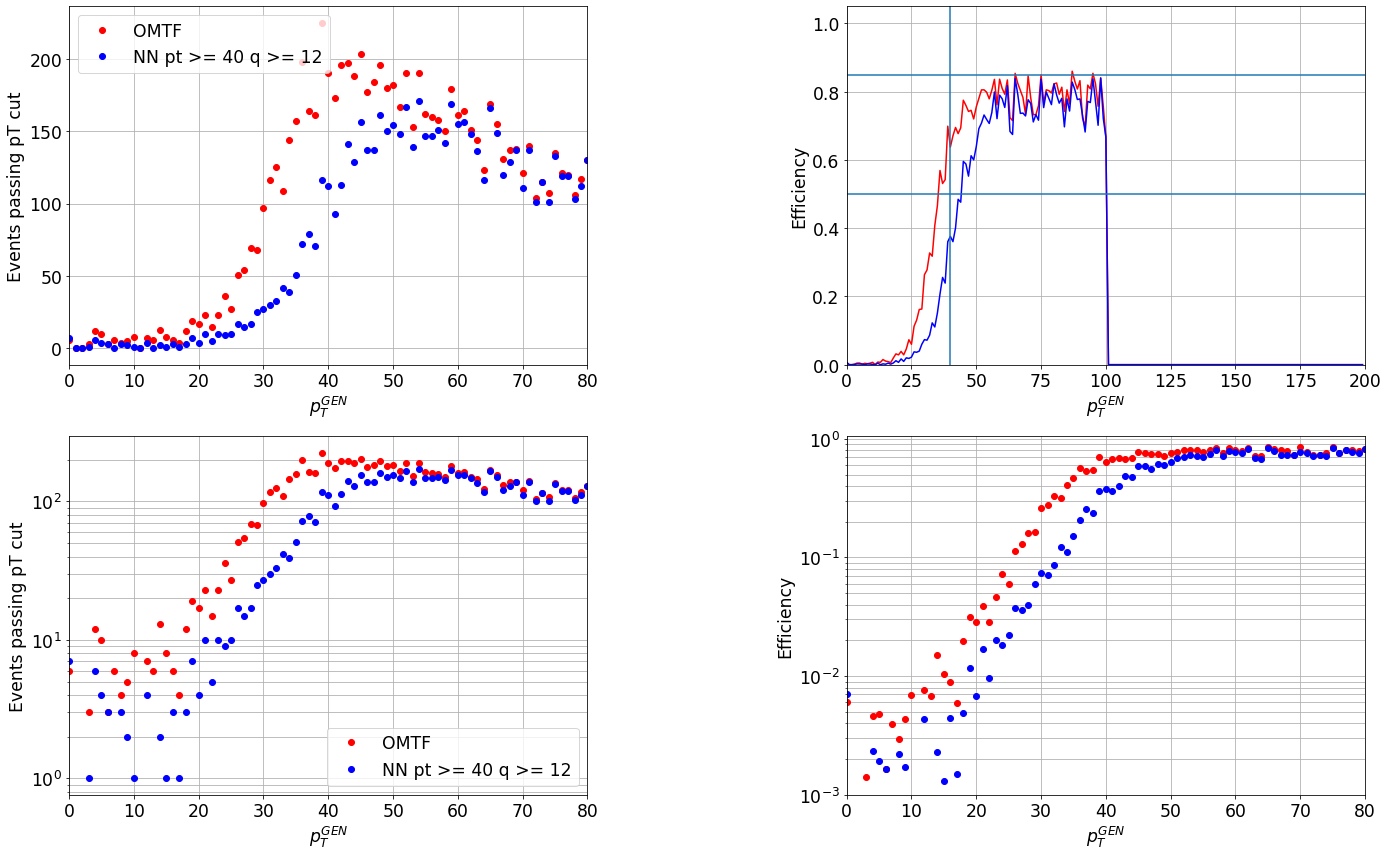

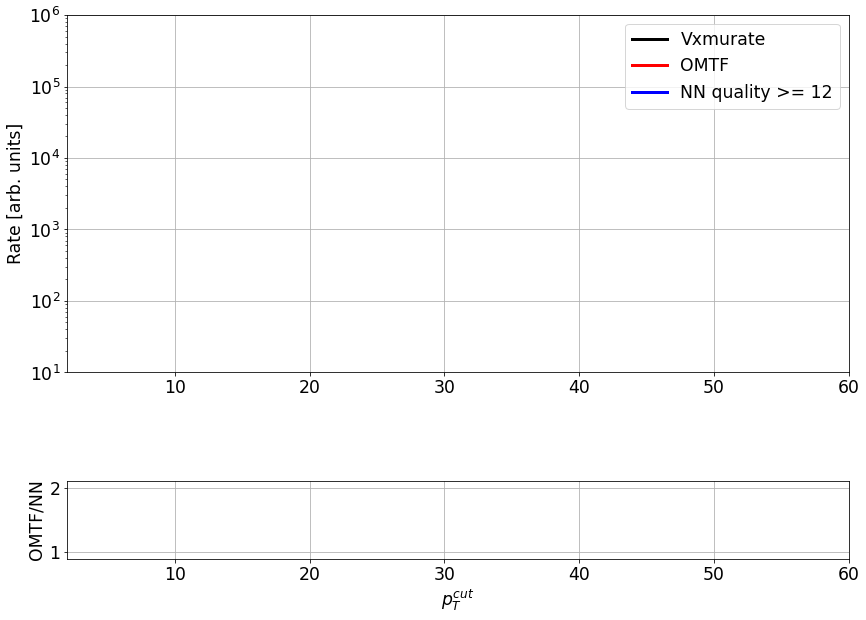

In [6]:
import plotting_functions as plf
importlib.reload(plf)

import utility_functions as utils
importlib.reload(utils)

fileName = job_dir+"/performance.txt"
utils.calculateLossFunctions(df, fileName)

plf.plotPtGenPtRec(df, plot_dir, oneOverPt)

for ptCut in plf.ptCuts :
    effStr, _, _ = plf.plotTurnOn(df, ptCut=ptCut, qualityCut = plf.qualityCut, plotDir=plot_dir)
    utils.appendStringToFile(effStr, fileName)
    print(effStr)

ratesStr = plf.plotRate(df, plf.qualityCut, plotDir=plot_dir)
print("rates NN", ratesStr)

utils.appendStringToFile(ratesStr, fileName)